In [1]:
from alive_progress import alive_bar

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
%matplotlib inline
pd.set_option('display.max_columns', None)

device = 'cuda'

In [2]:
class ValveDataset(Dataset):
    def __init__(self, floc, eqn=False):
        self.bn = pd.read_csv(floc)
        self.data = self.bn.to_numpy()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
torch.set_default_device(device)
torch.multiprocessing.set_start_method('spawn', force=True)
torch.manual_seed(123)
np.random.seed(123)

file = '/home/arch/.datasets/games/games.csv'
ds = ValveDataset(file)

In [172]:
df = pd.read_csv('/home/arch/.datasets/games/games.csv')

In [173]:
df = df.drop(columns=['Metacritic score', 'Metacritic url', 'Score rank', 'Website', 'Support url', 'Support email', 'Screenshots', 'Movies'])
df = df.drop(df.loc[(df['About the game'].isna()) | (df['Developers'].isna()) | (df['Publishers'].isna()) | (df['Categories'].isna()) | (df['Genres'].isna())].index)
df['Reviews'] = df['Reviews'].fillna('')
df['Notes'] = df['Notes'].fillna('')
df.loc[df['Tags'].isnull(), 'Tags'] = df.loc[df['Tags'].isnull(), 'Tags'].apply(lambda x: [])
df = df.drop(df.loc[(df['Positive'] + df['Negative'] == 0) & (df['Average playtime forever'] == 0.0)].index)
df = df.drop(df.loc[(df['Price'] >= 100)].index)

In [174]:
dti = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
# dates = df['Release date'].apply(lambda x: [dti[x.split(' ')[0]], x.split(' ')[1]])
df.insert(2, 'Release year', df['Release date'].apply(lambda x: x.split(' ')[1] if (len(x.split(' ')) == 2) else x.split(' ')[2]), True)

In [175]:
df.insert(2, 'Release month', df['Release date'].apply(lambda x: dti[x.split(' ')[0]], True))

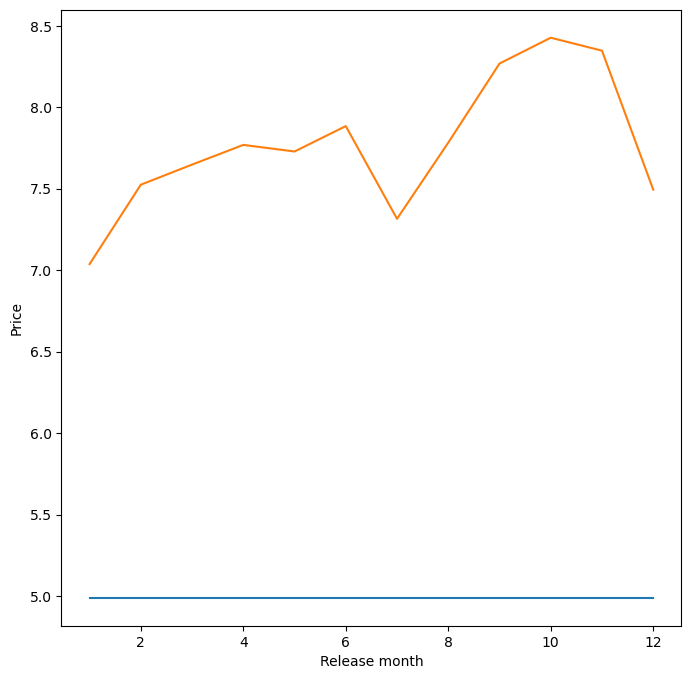

In [176]:
plt.figure(figsize=(8, 8))
perm = df.groupby(['Release month'])
plt.plot(perm['Release month'].mean(), perm['Price'].median())
plt.plot(perm['Release month'].mean(), perm['Price'].mean())
plt.xlabel('Release month')
plt.ylabel('Price')
plt.show()


In [178]:
import ast
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []
df['Release year'] = df['Release year'].apply(safe_literal_eval)
df['Supported languages'] = df['Supported languages'].apply(lambda x: len(x.split(' ')))

/tmp/ipykernel_64964/2869361811.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
/tmp/ipykernel_64964/2869361811.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


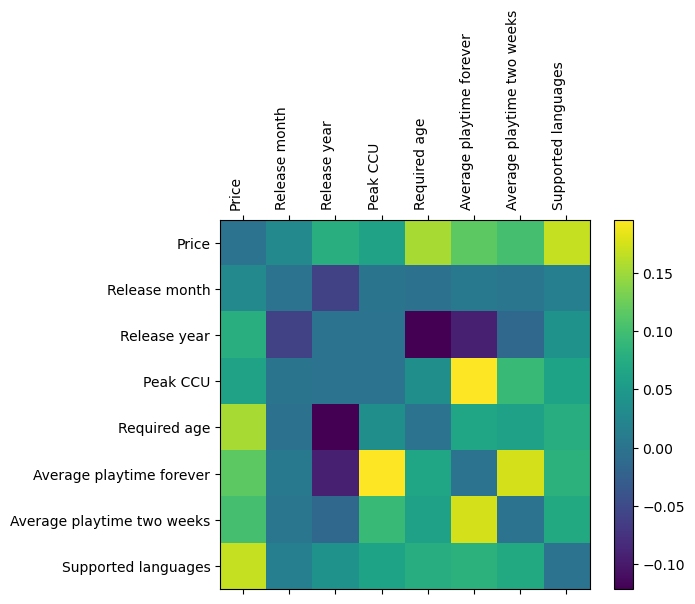

In [202]:
dfb = df[['Price', 'Release month', 'Release year', 'Peak CCU', 'Required age', 'Average playtime forever', 'Average playtime two weeks', 'Supported languages']]
alpha = ['Price', 'Release month', 'Release year', 'Peak CCU', 'Required age', 'Average playtime forever', 'Average playtime two weeks', 'Supported languages']
cor = dfb.corr().to_numpy()
for i in range(len(cor)):
    cor[i][i] = -0.0
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cor, interpolation='nearest')
fig.colorbar(cax)
ax.set_xticklabels(['']+alpha)
plt.xticks(rotation=90, ha='right')
ax.set_yticklabels(['']+alpha)

plt.show()